In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor

store_sales = pd.read_csv(
    './Data/store-sales-time_series-forecasting-train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={'store_nbr': 'category','family': 'category','sales': 'float32',},
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
family_sales = (store_sales.groupby(['family', 'date']).mean().unstack('family').loc['2017'])

class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

    def fit(self, X_1, X_2, y):
        self.model_1.fit(X_1, y)

        y_fit = pd.DataFrame(self.model_1.predict(X_1), index=X_1.index, columns=y.columns)

        # residuals
        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze()

        self.model_2.fit(X_2, y_resid)

        self.y_columns = y.columns
        self.y_fit = y_fit
        self.y_resid = y_resid

    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            # YOUR CODE HERE: predict with self.model_1
            self.model_1.predict(X_1),
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()  # wide to long

        # YOUR CODE HERE: add self.model_2 predictions to y_pred
        y_pred += self.model_2.predict(X_2)

        return y_pred.unstack()  # long to wide

In [18]:
# Target series
y = family_sales.loc[:, 'sales']


# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month
X_2

,family,onpromotion,day
date,,,
2017-01-01,0,0.000000,1
2017-01-01,1,0.000000,1
2017-01-01,2,0.000000,1
2017-01-01,3,0.703704,1
2017-01-01,4,0.000000,1
...,...,...,...
2017-08-15,28,0.111111,15
2017-08-15,29,0.166667,15
2017-08-15,30,58.685185,15


In [20]:
model = BoostedHybrid(model_1 = LinearRegression(), model_2 = XGBRegressor())

model.fit(X_1, X_2, y)
y_pred = model.predict(X_1, X_2)
y_pred = y_pred.clip(0.0)

In [21]:
from pyearth import Earth
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

model = BoostedHybrid(model_1=Ridge(), model_2=KNeighborsRegressor())

C:\Users\19498\AppData\Local\Temp\ipykernel_2908\1856624636.py:13: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
C:\Users\19498\AppData\Local\Temp\ipykernel_2908\1856624636.py:14: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)


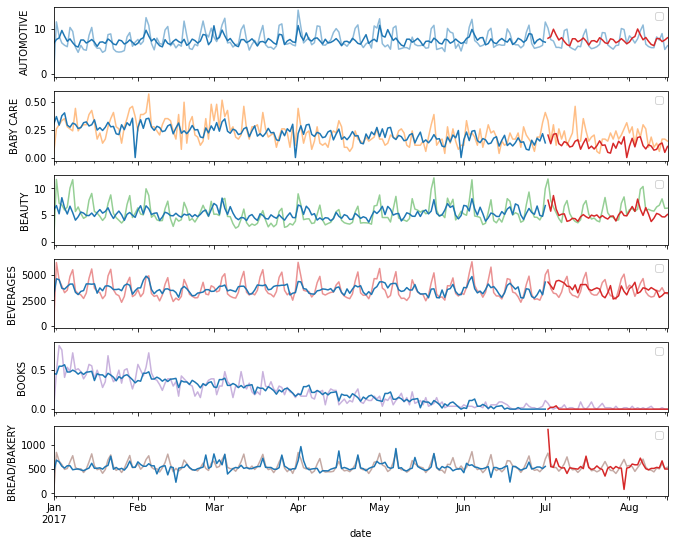

In [22]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(subplots=True, sharex=True, figsize=(11, 9), alpha=0.5)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)